## Section 1: Introduction to ID/ED set-shifting task

In [1]:
# This code block imports all necessary modules
import pandas as pd
import numpy as np
import os
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import emoji # Yes, this is also a necessary module

### 1.1 (Optional) Theoretical background

Attentional set is a predisposition to attend to a particular type of information that  predicts whether reward is given (e.g., either always rewarded or never rewarded). 

This can be measured in rats with a standard 7-stage ID/ED set-shifting task. Rats are presented with two bowls containing *digging medium* and scented with a particular *odour*. One of the two bowls contain a food reward and rats are motivated to select the correct bowl in order to retrieve it.

Suppose the location of the reward is revealed by odour: ginger-scented bowls contain reward and cinnamon-scented bowls do not. Then 'odour' is the *relevant* dimension and 'digging medium' is the *irrelevant* dimension. After repeated trials, rats *form an attentional set* for odour in that they upregulate attention to odour-type information and downregulate attention to medium-type information.

Next, we can make two types of meaningful switches.
1. Switch ginger with cinnamon: cinnamon-scented bowls are rewarded and ginger-scented bowls are not. This kind of switch is called a *reversal*.
2. Switch odour with medium: odour-based information is no longer consistently paired with reward/no-reward, rather digging medium predicts which bowl contains reward. This kind of switch is called a *dimensional shift*.

Dhawan et al. (2019) shows that reversals are dissociable from dimensional shifts since procedures which improve reversals, retard dimensional shifting. It is argued that reversals indicate *behavioural* flexibility while dimensional shifts indicate *cognitive* flexibility. 

An attentional set-shifting deficit is therefore a difficulty in reallocating attention from the previously relevant dimension (e.g., odour) to the now relevant dimension (e.g., medium), and indicates cognitive inflexibility. The data used for this assignment is collected to study whether mPFC deficts are associated with attentional set-shifting deficts.

In [2]:
# Create DataFrame for all compound-21 rats (experimental condition)
com = pd.concat(map(pd.read_csv, glob.glob('c*.csv'))) # Read all .csv files starting with 'c' into DataFrame
com['c/v'] = 'c' # Create column marking Compound-21(control) or Vehicle-treated(experimental) conditions

# Create DataFrame for all vehicle-treated rats (control condition)
veh = pd.concat(map(pd.read_csv, glob.glob('v*.csv'))) # Read all .csv files starting with 'v' into DataFrame
veh['c/v'] = 'v' # Create column marking Compound-21(control) or Vehicle-treated(experimental) conditions

# Combine all data into one DataFrame and mark condition (experimental/control) of data
rats = com.append(veh)

# Drop meaningless data. 'Omit/Note' contains no usable information (manually checked)
rats.drop(['nLatency', 'Omit/Note'], axis=1, inplace = True)

### 1.2 Definition of column labels

**RatID** ID number of rat tested. There are 12 rats in total labeled from 37 to 48.

**Stage** Stage of the standard 7-stage ID/ED set-shifting task. Stage names are explained below.

**Trial** Trial number within a certain stage for a certain rat; Trial: (RatID, Stage)

**Left medium** Digging medium placed in the left-side bowl.

**Left odour** Odour used to scent the left-side bowl.

**Right medium** Digging medium placed in the right-side bowl.

**Right odour** Odour used to scent the right-side bowl.

**Correct/Incorrect** 1 = rat dug in bowl with reward; 0 = rat dug in bowl without reward

**Rewarded** The stimulus that is paired with food reward.

**Investigation** Choice 1 = rat dug in the first bowl encountered; Choice 2 = rat rejected the first bowl encountered and dug in second bowl

**Latency** Duration of each trial in seconds

**First Response (side)** Side of the bowl rat first encountered

**First Response (correct?)** Whether the first encountered bowl contained reward

**c/v** Trial condition; c = Compound-21/experimental condition, v = Vehicle-treated/control condition

In [3]:
# Show resulting DataFrames
rats.head()

,RatID,Stage,Trial,Left Medium,Left Odor,Right Medium,Right Odor,Correct/Incorrect,Rewarded,Investigation,Latency,First Response (side),First Response (correct?),c/v
0,37,SD,1,M3,O,M4,O,0,M3,Choice 1,13,R,0.0,c
1,37,SD,2,M4,O,M3,O,1,M3,Choice 1,5,R,1.0,c
2,37,SD,3,M4,O,M3,O,1,M3,Choice 1,4,R,1.0,c
3,37,SD,4,M3,O,M4,O,0,M3,Choice 1,5,R,0.0,c
4,37,SD,5,M4,O,M3,O,1,M3,Choice 1,4,R,1.0,c


### 1.3 Experimental question & design 
Question: **Do rats with an inhibited medial prefrontal cortex (mPFC) have an attentional set-shifting deficit?**

This is a **within-subjects** design. All **twelve** rats were bilaterally injected at the mPFC with AAV5-CaMKIIa-hM4D(Gi)-mCherry viral vector, which has an inhibitory effect when activated by Compound-21. 

In the **control** condition, rats were orally administered with Vehicle so **no mPFC inhibition** occurs. 

In the **experimental** condition, rats were administered with Compound-21, resulting in **mPFC inhibition**. 

The **number of trials** required to hit six continous correct responses (trial-to-criterion; TTC) at each stage is measured. 

The **amount of time** spent on each trial ('latency') is also recorded but not analysed.

**Behavioural task** *Seven stages of a standard 7-stage ID/ED set-shifting task, listed in order*

When a rat gives the correct response 6 times in a row/reached criterion, the experimenter moves on the next stage.

| Stage                                    | Description     | Example bowls | Reward scheme |
|------------------------------------------|-----------------|---------------|-----------------|
|1. *Simple discrimination (SD)*           | Bowls contain only one type of information <br/> Rats are trained to use this cue to locate reward. | [(ginger, sawdust), (cinnamon, sawdust)] | ginger=1 </br> cinnamon=0 </br> sawdust=0 |
|2. *Compound discrimination (CD)*         | The second dimension is added to bowls. Rats are trained to continue using the original cue learnt from SD to locate reward. | [(ginger, sawdust), (cinnamon, sawdust)] | ginger=1 </br> cinnamon=0 </br> sawdust=0 |
|3. *First reversal (REV1)*                | The rewarded stimulus is switched with the unrewarded stimulus within the same dimension. | [(ginger, sand), (cinnamon, grit)] <br/> OR [(ginger, grit), (cinnamon, sand)] | ginger=0 </br> cinnamon=1 </br> sand=0 </br> grit=0 |
|4. *Intra-dimensional discrimination (ID)*| Novel stimuli are introduced but relevant dimension retains. | [(mint, coarse tea), (oregano, fine tea)] </br> OR [(mint, fine tea), (oregano, coarse tea)] | mint=1 </br> oregano=0 </br> coarse tea=0 </br> fine tea=0 |
|5. *Second reversal (REV2)*               | The novel rewarded stimulus is switched with the novel unrewarded stimulus within the same original dimension. | [(mint, coarse tea), (oregano, fine tea)] </br> OR [(mint, fine tea), (oregano, coarse tea)] | mint=0 </br> oregano=1 </br> coarse tea=0 </br> fine tea=0 |
|6. *Extra-dimensional discrimination (ED)*| Novel stimuli are introduced and relevant dimension switches. | [(turmeric, coarse shavings), (cloves, fine shavings)] </br> OR [(turmeric, fine shavings), (cloves, coarse shavings)] | turmeric=0 </br> cloves=0 </br> coarse shavings=1 </br> fine shavings=0 |
|7. *Third reversal (REV3)*                | The novel rewarded stimulus is switched with the novel unrewarded stimulus within the same new dimension. | [(turmeric, coarse shavings), (cloves, fine shavings)] </br> OR [(turmeric, fine shavings), (cloves, coarse shavings)] | turmeric=0 </br> cloves=0 </br> coarse shavings=0 </br> fine shavings=1 |

In [4]:
# This code block replaces stage names with the order of the stage in 
    # the entire 7-stage task to facilitate plotting.
for i in range(2110):
    rats.loc[rats['Stage']=='SD', 'Stage']=1
    rats.loc[rats['Stage']=='CD', 'Stage']=2
    rats.loc[rats['Stage']=='REV1', 'Stage']=3
    rats.loc[rats['Stage']=='ID', 'Stage']=4
    rats.loc[rats['Stage']=='REV2', 'Stage']=5
    rats.loc[rats['Stage']=='ED', 'Stage']=6
    rats.loc[rats['Stage']=='REV3', 'Stage']=7

## Section 2: Obtaining basic answers

### 2.1 Manipulation check: did rats form attentional sets (for the original dimension)? 
Number of trials required to reach task criterion (TTC) at each stage is visualised in the graph below. It shows that TTC in the extra-dimensional discrimination stage (ED) is greater than that in intra-dimensional discrimination stage (ID) for both control ('Vehicle') condition and experimental ('Compound-21') condition. This shows that an attentional set was formed in **both** conditions: during ED, attentional set for the original dimension *obstructs* learning novel information from the previously irrelevant, now relevant dimension, while no such obstruction exists during the ID, where the stimuli are also novel but the reward-predicting information is still in the original dimension.

### 2.2 Do results from this dataset reject the hypothesis?
Notably, rats administered with Compound-21 require a greater number of trials in ED than rats administered with Vehicle. This supports/does not reject the hypothesis that mPFC inhibition is associated with attentional set-shifting deficits.

In [5]:
# This code block computes the number of trials required to reach 
    # task criterion (TTC) , i.e., six correct in a row
    
ttc = pd.DataFrame() # Initialise pandas DataFrame

veh = rats[rats['c/v']=='v'] # Select control condition ('vehicle') data
veh = veh[['RatID', 'Stage', 'Trial']] # Remove data meaningless after .groupby
ttc['Vehicle'] = veh.groupby(['RatID', 'Stage']).max() # Obtain TTC for each stage & organise into MultiIndex by rat and stage

com = rats[rats['c/v']=='c'] # Select experimental condition ('compound-21') data
com = com[['RatID', 'Stage', 'Trial']] # Remove data meaningless after .groupby
ttc['Compound-21'] = com.groupby(['RatID', 'Stage']).max() # Obtain TTC for each stage & organise into MultiIndex by rat and stage

ttc.sort_values(['RatID','Stage'], inplace = True) # Sort DataFrame by rat ID and stage order
ttc.loc[37, 3] # Locate data for a rat in a particular stage with ttc.loc[<RatID>, <Stage>]

Vehicle        25
Compound-21    20
Name: (37, 3), dtype: int64

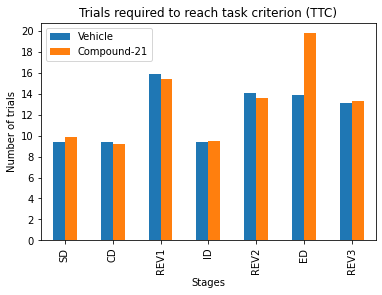

In [6]:
ttc_stage = ttc.groupby('Stage').mean()
ttc_stage['Stages'] = ['SD', 'CD', 'REV1', 'ID', 'REV2', 'ED', 'REV3']

ttc_stage.plot(x='Stages', y=["Vehicle", 'Compound-21'], kind="bar")
# Specifies y-axis, and title labels.
plt.ylabel('Number of trials')
plt.title('Trials required to reach task criterion (TTC)')

# Specifies y-ticks as integers
plt.yticks(np.arange(0, 22, 2));

## Section 3: Questioning the assumptions

### 3.1 Are rats' individal task efficiency consistent between experimental conditions?
As this is a within-subjects design, it is assumed that rats' efficiency at solving the task is consistent between experimental conditions, so that any difference in performance is attributed to the effect of mPFC inhibition. Rats' TTC in experimental condition is regressed over that in control condition. A positive correlation is expected: the lower the task efficiency in control condition, the lower the task efficiency should be in experimental conditions. Task efficiency is inversely proportional to TTC, i.e., the greater number of trials required to reach criterion, the lower the task efficiency.

The assumption is supported as shown by the positive sloped regression line indicating a positive correlation. However, the correlation is weak/the slope is not steep. By eyeballing the trend of individual rats in the second graph, it appears that consistency varies greatly between rats, as their datapoints do not share similar distribution patterns. Nevertheless, it is clear that TTC is generally lower in control than in experimental condition, as datapoints are more dense on the left side of the graph, but roughly equally spanning both top and bottom.

C:\Users\hilar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


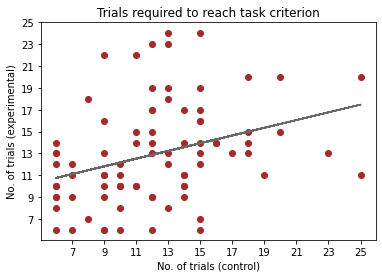

In [7]:
# Intialise two pandas Series for Vehicle (control) rats and Compound-21 (experimental) rats
Ve = pd.Series(dtype='float64')
Co = pd.Series(dtype='float64')

# Build pandas Series to contain trial to criterion information for each experimental condition
    # and plots information as a scatter plot
for r in range(37,49): # Loops the following code for all 12 rats
    Ve = Ve.append(ttc.xs(r)['Vehicle']) # TTC for vehicle/control rats
    Co = Co.append(ttc.xs(r)['Compound-21']) # TTC for compound-21/experimental rats
    plt.scatter(ttc.xs(r)['Vehicle'], ttc.xs(r)['Compound-21'], c = 'brown')
    
# Specifies x-axis, y-axis, and title labels.
plt.xlabel('Control (trials)')
plt.ylabel('Experimental (trials)')
plt.title('Trials required to reach task criterion')

# Initialise linear regression model
model = LinearRegression()

# Shapes Ve into a 2-D numpy array
Ve_np = Ve[:, np.newaxis]

# Fit model with TTC data in control (Ve) and experimental (Co) conditions
model.fit(Ve_np, Co)

# Predict TTC in experimental condition based on control. This forms the regression line
Cofit = model.predict(Ve_np)

# Visualise regression line by plotting on the same graph
plt.plot(Ve_np, Cofit, color='dimgrey');

# Specify x-axis and y-axis as integers for easier graph interpretation
plt.xticks(np.arange(7, 27, 2))
plt.yticks(np.arange(7, 27, 2));

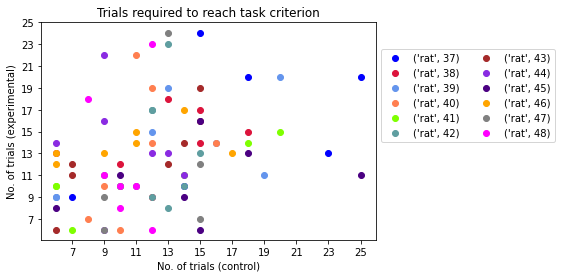

In [8]:
# Specifies twelve distinct colours for scatterplot
colours = ['blue', 'crimson', 'cornflowerblue', 'coral', 'chartreuse', 'cadetblue', 'brown', 'blueviolet', 'indigo', 'orange', 'grey', 'magenta']

# Build pandas Series to contain trial to criterion information for each experimental condition
    # and plots information as a scatter plot
for r in range(37,49): # Loops the following code for all 12 rats
    plt.scatter(ttc.xs(r)['Vehicle'], ttc.xs(r)['Compound-21'], label=('rat', r), c = colours[r-37])
    
# Specifies x-axis, y-axis, and title labels.
plt.xlabel('Control (trials)')
plt.ylabel('Experimental (trials)')
plt.title('Trials required to reach task criterion')

# Fix legend at x_0 = 1, y_0 = 0.6, height = 0.55, width = 0.3 and organised as 2 columns
plt.legend(bbox_to_anchor=(1, 0.6, 0.55, 0.3), mode = "expand", ncol = 2) 

# Specify x-axis and y-axis as integers for easier graph interpretation
plt.xticks(np.arange(7, 27, 2))
plt.yticks(np.arange(7, 27, 2));


In [9]:
# Visualises twelve adult male Lister-hooded rats
print(emoji.emojize(':rat: :rat: :rat: :rat: :rat: :rat: :rat: :rat: :rat: :rat: :rat: :rat:'))

🐀 🐀 🐀 🐀 🐀 🐀 🐀 🐀 🐀 🐀 🐀 🐀


### 3.2 Is hitting six continuous correct responses a reliable indicator of learning an association?

To fully answer this question, data on rats' performance *after* reaching criterion is needed, which means that rats need to be *overtrained* for collecting that data. As that is not available, I will partially answer this question by examining rats' performance before reaching criterion. 

The criterion of 'six continuous hits' is artifically set by experimentors to indicate rats have learnt the association between stimulus and reward in any given stage. By this standard, responses prior to criterion are not made based on the learnt association; they are 'noisy' responses. 

What do 'noisy' responses mean? That depends on how rats making decisions before using the learnt association between stimulus and reward. If they were completely choosing by chance, the expected % of noisy hits/correct responses would be 50%. In the graph below, linear regression line does not match the 50% correct cut-off line, suggesting rats are not choosing by chance. 

Suppose noisy responses reflect a learning process, what do noisy hits indicate? The positive slope linear regression line means that the greater TTC, the more correct noisy responses were made. Assuming greater TTC = lower learning efficiency, this would mean that *the more correct responses made prior to actually learning the association, the poorer the rat is at learning the target association.*

C:\Users\hilar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:36: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


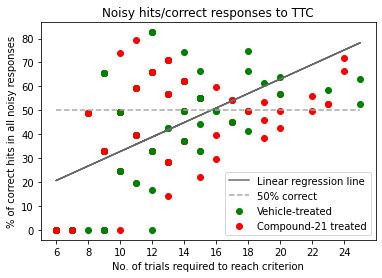

In [10]:
# This code block computes the number of correct responses 
    # before TTC is reached and the rat proceeds to the next stage.
    
cor = pd.DataFrame() # Initialise pandas DataFrame

veh = rats[rats['c/v']=='v'] # Select control condition ('vehicle') data
veh = veh[['RatID', 'Stage', 'Correct/Incorrect']] # Remove data meaningless after .groupby
cor['Vehicle'] = veh.groupby(['RatID', 'Stage']).sum() # Obtain no. of correct responses for each stage & organise into MultiIndex by rat and stage

com = rats[rats['c/v']=='c'] # Select experimental condition ('compound-21') data
com = com[['RatID', 'Stage', 'Correct/Incorrect']] # Remove data meaningless after .groupby
cor['Compound-21'] = com.groupby(['RatID', 'Stage']).sum() # Obtain no. of correct responses for each stage & organise into MultiIndex by rat and stage

cor.sort_values(['RatID','Stage'], inplace = True) # Sort DataFrame by rat ID and stage order

prop = (cor - 6)*100/(ttc - 5.95) # Proportion of correct responses to all noisy responses. Instead of taking the 6 criterion trials out from total TTC, 5.95 was used to avoid dividing by 0 where no noisy trials occurred.

T = pd.Series(dtype='float64')
P = pd.Series(dtype='float64')
for r in range(37,49): # Loops the following code for all 12 rats
    T = T.append(ttc.xs(r)['Vehicle']) # TTC for vehicle/control rats
    T = T.append(ttc.xs(r)['Compound-21']) # TTC for vehicle/control rats
    P = P.append(prop.xs(r)['Vehicle']) # TTC for compound-21/experimental rats
    P = P.append(prop.xs(r)['Compound-21']) # TTC for compound-21/experimental rats
    plt.scatter(ttc.xs(r)['Vehicle'], prop.xs(r)['Vehicle'], color = 'green')
    plt.scatter(ttc.xs(r)['Compound-21'], prop.xs(r)['Compound-21'], color = 'red')

# Specify x-axis and y-axis as integers for easier graph interpretation
plt.xticks(np.arange(6, 28, 2))
plt.yticks(np.arange(0, 100, 10))

# Initialise linear regression model
model1 = LinearRegression()

# Shapes Ve into a 2-D numpy array
T_np = T[:, np.newaxis]

# Fit model with TTC data in control (Ve) and experimental (Co) conditions
model.fit(T_np, P)

# Predict TTC in experimental condition based on control. This forms the regression line
Pfit = model.predict(T_np)

# Visualise regression line by plotting on the same graph
plt.plot(T_np, Pfit, color='dimgrey')

x = [6, 25]
y = [50, 50]
plt.plot(x, y, linestyle = '--', c = 'darkgrey')

# Specifies x-axis, y-axis, legend, and title labels.
plt.xlabel('TTC (trials)')
plt.ylabel('% of correct hits in all noisy responses')
plt.title('Noisy hits/correct responses to TTC')
plt.legend(['Linear regression line' , '50% correct','Vehicle-treated', 'Compound-21 treated'], loc='best');

### 3.3 Is shifting from medium to odour-based discrimination the same as shifting from odour to medium-based discrimination?

The direction of dimensional shift is counterbalanced: six rats shift from medium to odour-based discrimination in the ED while the other six rats shift from odour to medium-based discrimination in the ED. This assumes that attentional set-shifting underlying the shift in both directions is the same cognitive process. 

The graph below shows trials within odour-to-medium (O to M) shifts in blue shades and trials within medium-to-odour (M to O) shifts in red shades. The majority of high latency trials are completed within O to M shifts while there are more trials within M to O shifts, indicating M to O shifts generally require a higher TTC. 

Arguably, latency measures the length of cognitive processes involved in completing shifts and TTC measures efficiency in solving the task. Then this graph suggests that O to M shifts involve cognitive processes that take longer than that to complete M to O, but is completed with an overall higher efficiency. In contrast, M to O shifts involve shorter cognitive processes but has an overall lower efficiency, requiring greater TTC.

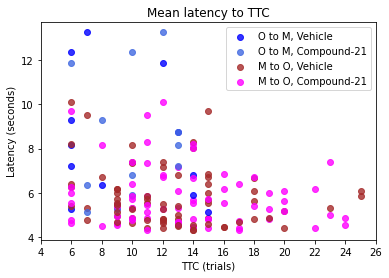

In [69]:
# Returns true if rats shifted from odour-discrimination to medium-discrimination during ED
rats['O to M'] = (rats['Stage']==1) & (rats['Left Odor'] == 'O')

# Creates two-level DataFrame with average latency grouped by rat and stage
lat = rats[['RatID', 'Stage', 'Latency']].groupby(['RatID', 'Stage']).mean()
# Creates two-lvel DataFrame recording shift direction of rat, sorted by rat and stage
shift = rats[['RatID', 'Stage', 'O to M']].groupby(['RatID', 'Stage']).max()
# Create two-level DataFrame containing all information organised on two levels.
idst = ttc
idst['Latency'] = lat
idst['O to M'] = shift

# This loop plots the trial to criterion to latency and marks 
    # trials' shift direction and experimental condition with different colours
for r in range(37,49): # Loops through each rat
    for s in range(1,8): # Loops through each stage
        if idst.loc[r,s]['O to M'] == True: # Select trials shifting from odour to medium
            plt.scatter(idst.loc[r,s]['Vehicle'], idst.loc[r,s]['Latency'], c = 'blue', alpha = 0.8) # Plot O to M trials in vehicle condition
            plt.scatter(idst.loc[r,s]['Compound-21'], idst.loc[r,s]['Latency'], c = 'royalblue', alpha = 0.8) # Plot O to M trials in Compound-21 condition
        else: # Selects trials shifting from medium to odour
            plt.scatter(idst.loc[r,s]['Vehicle'], idst.loc[r,s]['Latency'], c = 'brown', alpha = 0.8) # Plot M to O trials in vehicle condition
            plt.scatter(idst.loc[r,s]['Compound-21'], idst.loc[r,s]['Latency'], c = 'magenta', alpha = 0.8) # Plot M to O trials in Compound-21 condition

# Specifies x-, y-axis labels, title, legend, and x-ticks
plt.xlabel('TTC (trials)')
plt.ylabel('Latency (seconds)')
plt.title('Mean latency to TTC')
plt.legend(['O to M, Vehicle', 'O to M, Compound-21', 'M to O, Vehicle', 'M to O, Compound-21'], loc = 'best')
plt.xticks(np.arange(4,28,2));

In [34]:
ttc.xs()

Vehicle  Compound-21
RatID Stage                      
37    1           14           10
      2           10           10
      3           25           20
      4            7            9
      5           23           13
...              ...          ...
48    3            8           18
      4           10            8
      5           11           10
      6           12           23
      7            9           11

[84 rows x 2 columns]

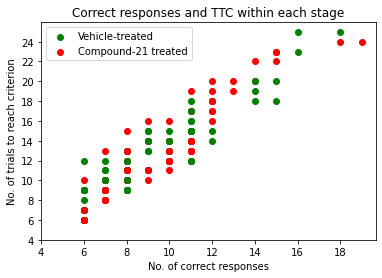

In [12]:
for r in range(37,49): # Loops the following code for all 12 rats
    plt.scatter(cor.xs(r)['Vehicle'], ttc.xs(r)['Vehicle'], color = 'green')
    plt.scatter(cor.xs(r)['Compound-21'], ttc.xs(r)['Compound-21'], color = 'red')

# Specify x-axis and y-axis as integers for easier graph interpretation
plt.xticks(np.arange(4, 20, 2))
plt.yticks(np.arange(4, 26, 2));

# Specifies x-axis, y-axis, legend, and title labels.
plt.xlabel('No. of correct responses')
plt.ylabel('No. of trials to reach criterion')
plt.title('Correct responses and TTC within each stage')
plt.legend(['Vehicle-treated', 'Compound-21 treated'], loc='best');

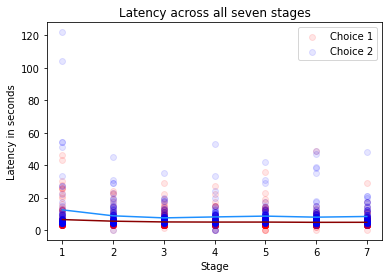

In [13]:
choice1 = rats[rats['Investigation']=='Choice 1']
choice2 = rats[rats['Investigation']=='Choice 2']
lat_avg1 = choice1.groupby('Stage').mean()
lat_avg2 = choice2.groupby('Stage').mean()

plt.scatter(choice1['Stage'], choice1['Latency'], color = 'r', label = 'Choice 1', alpha = 0.1)
plt.scatter(choice2['Stage'], choice2['Latency'], color = 'b', label = 'Choice 2', alpha = 0.1)
plt.plot(lat_avg1.index, lat_avg1['Latency'], color = 'darkred')
plt.plot(lat_avg2.index, lat_avg2['Latency'], color = 'dodgerblue')
plt.ylabel('Latency in seconds')
plt.xlabel('Stage')
plt.title('Latency across all seven stages')
plt.legend(loc='best');

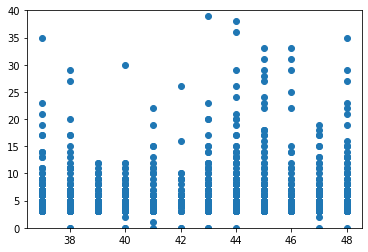

In [14]:
plt.scatter(rats['RatID'], rats['Latency'])
plt.ylim(0,40);